In [1]:
# Load modules

import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import sys
import os
sys.path.append('..')
from types import SimpleNamespace
from field_of_junctions import FieldOfJunctions
import nbimporter

from torchsummary import summary

from Dataset_Maker_Lines import make_random_line_set, make_grey_transform
from Dataset_Maker_Junctions import make_random_junction_set, make_grey_transform_junc

# %load_ext autoreload
# %reload_ext autoreload

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# %load_ext autoreload
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


In [3]:
class LineDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, wedges, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.wedges = wedges
        self.transform = transform

    def __getitem__(self, index):
        
        image = self.images[index]
        wedge = self.wedges[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index].squeeze()
        boundary = self.boundaries[index]
        
        return image, param, boundary, wedge

    def __len__(self):
        return len(self.images)

In [4]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('LazyLinear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0) 
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
    if classname.find('Conv2d') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

# Learn 5x5 patches

In [40]:
# Load dataset 

data_folder = 'foj_data/grayscale_lines/'

with open(data_folder + 'line_data_5_100000_grey_multicolor_with_solid_with_junc_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_125000_grey_bicolor_with_solid_noise_random_.2_uncentered.pkl','rb') as f:
# with open(data_folder + 'line_data_5_100000_grey_bicolor_noise_random_.2_uncentered.pkl','rb') as f:


    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

135000


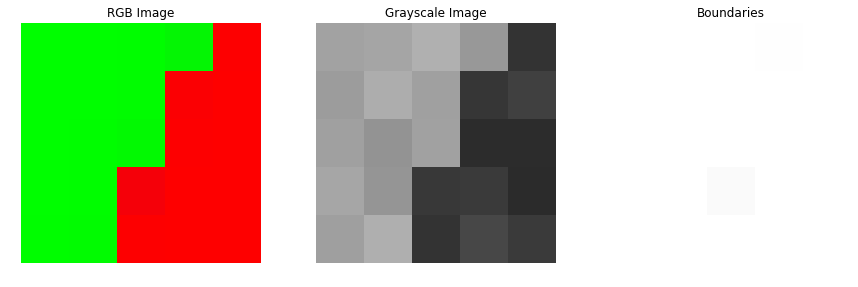

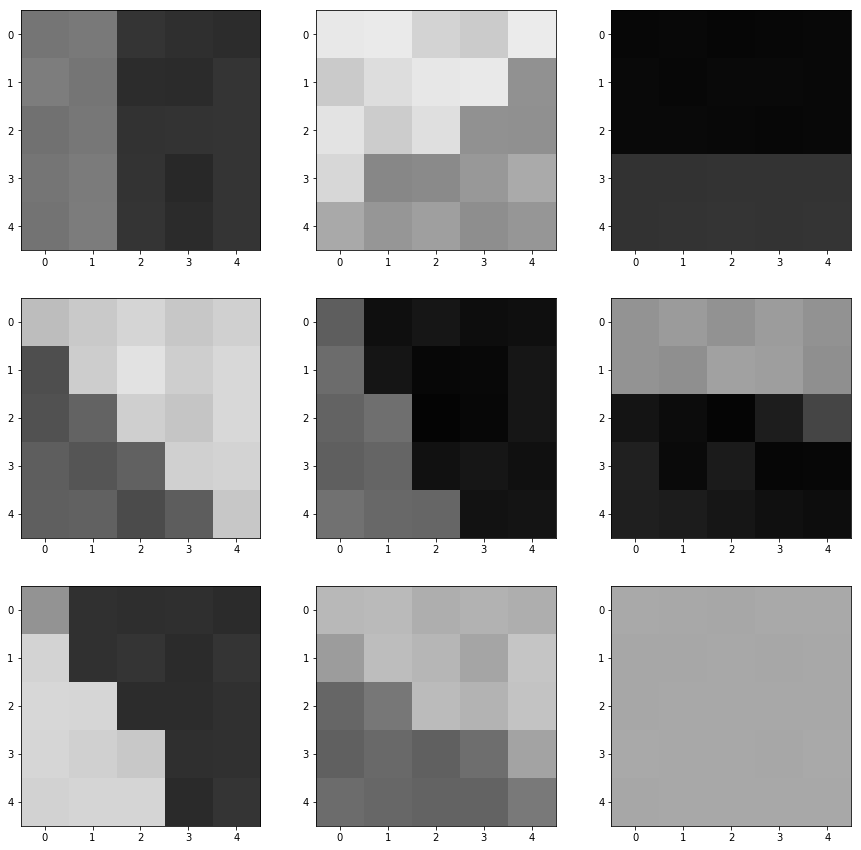

In [50]:
line_data = LineDataset(wedges_grey, params, boundaries, wedges)#, transform=trainTransform)
data_size = len(line_data)

print(data_size)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(line_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


W,H = wedges_grey.shape[-1],wedges_grey.shape[-1]

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(331)
plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
plt.title('RGB Image')
plt.axis('off');
plt.subplot(332)
plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(333)
plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

plt.figure(figsize=[15, 15])

for ii in range(9):
    
    plt.subplot(3,3,ii+1)
    plt.imshow(wedges_grey[torch.randint(data_size,[1]),:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
#     print(params[-ii,:])

# img_show = 1
# plt.subplot(334)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(335)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(336)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');

# img_show = 2
# plt.subplot(337)
# plt.imshow(wedges[img_show,:,:].squeeze().permute(1,2,0).cpu())
# plt.title('RGB Image')
# plt.axis('off');
# plt.subplot(338)
# plt.imshow(wedges_grey[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Grayscale Image')
# plt.axis('off');
# plt.subplot(339)
# plt.imshow(boundaries[img_show,:,:].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
# plt.title('Boundaries')
# plt.axis('off');



In [51]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.LazyBatchNorm1d()
    
    def forward(self, x):

#         x = self.batchnorm(x)
        x = self.conv1(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = self.conv2(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = self.conv3(x)
#         x = self.batchnorm(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
model = offCenterLineNet()
model = model.to(dev)
summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 4]              80
              ReLU-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 16, 3, 3]           1,040
              ReLU-4             [-1, 16, 3, 3]               0
            Conv2d-5             [-1, 32, 2, 2]           2,080
              ReLU-6             [-1, 32, 2, 2]               0
            Linear-7                    [-1, 3]             387
Total params: 3,587
Trainable params: 3,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


Epoch: 1, Avg. Train Loss: 1.9373639324437018, Avg. Test Loss: 1.8157429695129395
Epoch: 2, Avg. Train Loss: 1.774813493438389, Avg. Test Loss: 1.7165343761444092
Epoch: 3, Avg. Train Loss: 1.7053155204524164, Avg. Test Loss: 1.665329098701477
Epoch: 4, Avg. Train Loss: 1.6466181589209514, Avg. Test Loss: 1.5879017114639282
Epoch: 5, Avg. Train Loss: 1.1707540600196176, Avg. Test Loss: 0.8560585975646973
Epoch: 6, Avg. Train Loss: 0.8410875082015992, Avg. Test Loss: 0.7652318477630615
Epoch: 7, Avg. Train Loss: 0.7640123134074004, Avg. Test Loss: 0.7205123901367188
Epoch: 8, Avg. Train Loss: 0.7140524299248405, Avg. Test Loss: 0.6788102388381958
Epoch: 9, Avg. Train Loss: 0.6710477968920832, Avg. Test Loss: 0.6260446310043335
Epoch: 10, Avg. Train Loss: 1.0635825939800427, Avg. Test Loss: 1.5992159843444824
Epoch: 11, Avg. Train Loss: 1.7362610796223517, Avg. Test Loss: 2.0352096557617188
Epoch: 12, Avg. Train Loss: 2.046083931300951, Avg. Test Loss: 2.058993101119995
Epoch: 13, Avg. T

Epoch: 101, Avg. Train Loss: 0.9771122533342113, Avg. Test Loss: 0.9191626310348511
Epoch: 102, Avg. Train Loss: 0.9613002227700275, Avg. Test Loss: 0.9056262373924255
Epoch: 103, Avg. Train Loss: 0.9473370930422907, Avg. Test Loss: 0.8854537010192871
Epoch: 104, Avg. Train Loss: 0.9333636537842128, Avg. Test Loss: 0.8817644715309143
Epoch: 105, Avg. Train Loss: 0.9160459290380063, Avg. Test Loss: 0.8619486093521118
Epoch: 106, Avg. Train Loss: 1.0127213675042857, Avg. Test Loss: 0.9976034164428711
Epoch: 107, Avg. Train Loss: 1.0849636476972828, Avg. Test Loss: 1.134500503540039
Epoch: 108, Avg. Train Loss: 1.1939690916434578, Avg. Test Loss: 1.1200475692749023
Epoch: 109, Avg. Train Loss: 1.168110814301864, Avg. Test Loss: 1.0668889284133911
Epoch: 110, Avg. Train Loss: 1.3026964622995127, Avg. Test Loss: 1.2325130701065063
Epoch: 111, Avg. Train Loss: 1.2644497943961102, Avg. Test Loss: 1.2002067565917969
Epoch: 112, Avg. Train Loss: 1.2201332931933195, Avg. Test Loss: 1.16712057590

Epoch: 200, Avg. Train Loss: 1.3695943873861562, Avg. Test Loss: 1.3316541910171509
Epoch: 201, Avg. Train Loss: 1.3485021777774977, Avg. Test Loss: 1.3064892292022705
Epoch: 202, Avg. Train Loss: 1.3237603032070657, Avg. Test Loss: 1.290366291999817
Epoch: 203, Avg. Train Loss: 1.3159039248590885, Avg. Test Loss: 1.2863743305206299
Epoch: 204, Avg. Train Loss: 1.3094247123469478, Avg. Test Loss: 1.278490424156189
Epoch: 205, Avg. Train Loss: 1.3045933681985606, Avg. Test Loss: 1.271939754486084
Epoch: 206, Avg. Train Loss: 1.300715154150258, Avg. Test Loss: 1.2713165283203125
Epoch: 207, Avg. Train Loss: 1.295979672929515, Avg. Test Loss: 1.2638026475906372
Epoch: 208, Avg. Train Loss: 1.290627096010291, Avg. Test Loss: 1.2583012580871582
Epoch: 209, Avg. Train Loss: 1.2865611947101094, Avg. Test Loss: 1.2536087036132812
Epoch: 210, Avg. Train Loss: 1.2826245017673659, Avg. Test Loss: 1.236950397491455
Epoch: 211, Avg. Train Loss: 1.4266531322313392, Avg. Test Loss: 1.2486724853515625

Epoch: 298, Avg. Train Loss: 0.7539635803388512, Avg. Test Loss: 0.7080512046813965
Epoch: 299, Avg. Train Loss: 0.749262319440427, Avg. Test Loss: 0.7032181024551392
Epoch: 300, Avg. Train Loss: 0.745874942385632, Avg. Test Loss: 0.7010726928710938
Epoch: 301, Avg. Train Loss: 0.7422857517781465, Avg. Test Loss: 0.6979466676712036
Epoch: 302, Avg. Train Loss: 0.7390026605647543, Avg. Test Loss: 0.6946487426757812
Epoch: 303, Avg. Train Loss: 0.7348757152972014, Avg. Test Loss: 0.6901552081108093
Epoch: 304, Avg. Train Loss: 0.7325406115988027, Avg. Test Loss: 0.6881581544876099
Epoch: 305, Avg. Train Loss: 0.7276221088741137, Avg. Test Loss: 0.6831880211830139
Epoch: 306, Avg. Train Loss: 0.7252870746280836, Avg. Test Loss: 0.6831420660018921
Epoch: 307, Avg. Train Loss: 0.7242810544760331, Avg. Test Loss: 0.6795573830604553
Epoch: 308, Avg. Train Loss: 0.7175891259442205, Avg. Test Loss: 0.6752541661262512
Epoch: 309, Avg. Train Loss: 0.7145683723947276, Avg. Test Loss: 0.67224377393

Epoch: 396, Avg. Train Loss: 0.6174734680548958, Avg. Test Loss: 0.6120674014091492
Epoch: 397, Avg. Train Loss: 0.6173834386079208, Avg. Test Loss: 1.0293753147125244
Epoch: 398, Avg. Train Loss: 1.7808044521704964, Avg. Test Loss: 1.4902563095092773
Epoch: 399, Avg. Train Loss: 2.0487185592236727, Avg. Test Loss: 1.8800626993179321
Epoch: 400, Avg. Train Loss: 2.0987472928088646, Avg. Test Loss: 1.4490827322006226
Epoch: 401, Avg. Train Loss: 1.4607843285021576, Avg. Test Loss: 1.4485441446304321
Epoch: 402, Avg. Train Loss: 1.4533591384473055, Avg. Test Loss: 1.437290072441101
Epoch: 403, Avg. Train Loss: 1.4423412126043569, Avg. Test Loss: 1.4259986877441406
Epoch: 404, Avg. Train Loss: 1.4308129756346992, Avg. Test Loss: 1.414753794670105
Epoch: 405, Avg. Train Loss: 1.4199112570804098, Avg. Test Loss: 1.403566598892212
Epoch: 406, Avg. Train Loss: 1.4088695049285889, Avg. Test Loss: 1.3924814462661743
Epoch: 407, Avg. Train Loss: 1.3978892233060753, Avg. Test Loss: 1.381555795669

Epoch: 494, Avg. Train Loss: 0.6033059659211532, Avg. Test Loss: 0.5865256190299988
Epoch: 495, Avg. Train Loss: 0.6019996772641721, Avg. Test Loss: 0.58747798204422
Epoch: 496, Avg. Train Loss: 0.600588361594988, Avg. Test Loss: 0.589102029800415
Epoch: 497, Avg. Train Loss: 0.5990660346072653, Avg. Test Loss: 0.5905122756958008
Epoch: 498, Avg. Train Loss: 0.5979501045268515, Avg. Test Loss: 0.6170210838317871
Epoch: 499, Avg. Train Loss: 0.5967161256334056, Avg. Test Loss: 0.6020647883415222
Epoch: 500, Avg. Train Loss: 0.5955859479696854, Avg. Test Loss: 0.5956740379333496
Epoch: 501, Avg. Train Loss: 0.5936726632325545, Avg. Test Loss: 0.5848702788352966
Epoch: 502, Avg. Train Loss: 0.5924727310305057, Avg. Test Loss: 0.5787534713745117
Epoch: 503, Avg. Train Loss: 0.5914889765822369, Avg. Test Loss: 0.5746217966079712
Epoch: 504, Avg. Train Loss: 0.5902303713819255, Avg. Test Loss: 0.5780231952667236
Epoch: 505, Avg. Train Loss: 0.5887118386185688, Avg. Test Loss: 0.5729228258132

Epoch: 592, Avg. Train Loss: 0.5145406121793, Avg. Test Loss: 0.5025982856750488
Epoch: 593, Avg. Train Loss: 0.513892680665721, Avg. Test Loss: 0.5008780360221863
Epoch: 594, Avg. Train Loss: 0.5129918891450633, Avg. Test Loss: 0.4993859529495239
Epoch: 595, Avg. Train Loss: 0.5121878066788549, Avg. Test Loss: 0.4998878240585327
Epoch: 596, Avg. Train Loss: 0.511948470706525, Avg. Test Loss: 0.49866610765457153
Epoch: 597, Avg. Train Loss: 0.5110214816487354, Avg. Test Loss: 0.497633695602417
Epoch: 598, Avg. Train Loss: 0.5102514326572418, Avg. Test Loss: 0.4975597858428955
Epoch: 599, Avg. Train Loss: 0.509493913339532, Avg. Test Loss: 0.4957250654697418
Epoch: 600, Avg. Train Loss: 0.5087093446565711, Avg. Test Loss: 0.49591192603111267
Epoch: 601, Avg. Train Loss: 0.5075709304083948, Avg. Test Loss: 0.4962003529071808
Epoch: 602, Avg. Train Loss: 0.5076279743858005, Avg. Test Loss: 0.4937255084514618
Epoch: 603, Avg. Train Loss: 0.5066668855107349, Avg. Test Loss: 0.49360421299934

Epoch: 689, Avg. Train Loss: 0.3506464859713679, Avg. Test Loss: 0.3404754400253296
Epoch: 690, Avg. Train Loss: 0.34941691056541774, Avg. Test Loss: 0.34009096026420593
Epoch: 691, Avg. Train Loss: 0.3476436988167141, Avg. Test Loss: 0.3378169536590576
Epoch: 692, Avg. Train Loss: 0.346127100094505, Avg. Test Loss: 0.3360859751701355
Epoch: 693, Avg. Train Loss: 0.3445019203683604, Avg. Test Loss: 0.3345504701137543
Epoch: 694, Avg. Train Loss: 0.3429141057574231, Avg. Test Loss: 0.33356714248657227
Epoch: 695, Avg. Train Loss: 0.3413193979988927, Avg. Test Loss: 0.3322570025920868
Epoch: 696, Avg. Train Loss: 0.33984573146571284, Avg. Test Loss: 0.33054205775260925
Epoch: 697, Avg. Train Loss: 0.3384127612995065, Avg. Test Loss: 0.3293820321559906
Epoch: 698, Avg. Train Loss: 0.3368054555810016, Avg. Test Loss: 0.3278902769088745
Epoch: 699, Avg. Train Loss: 0.3353368855041006, Avg. Test Loss: 0.32711225748062134
Epoch: 700, Avg. Train Loss: 0.334404477606649, Avg. Test Loss: 0.32676

Epoch: 786, Avg. Train Loss: 0.2641107960887577, Avg. Test Loss: 0.2641012668609619
Epoch: 787, Avg. Train Loss: 0.26327850831591565, Avg. Test Loss: 0.26855698227882385
Epoch: 788, Avg. Train Loss: 0.26295333284398786, Avg. Test Loss: 0.26385751366615295
Epoch: 789, Avg. Train Loss: 0.26228630555712656, Avg. Test Loss: 0.26285991072654724
Epoch: 790, Avg. Train Loss: 0.2622427744709927, Avg. Test Loss: 0.2624199092388153
Epoch: 791, Avg. Train Loss: 0.26220551690329674, Avg. Test Loss: 0.2637248635292053
Epoch: 792, Avg. Train Loss: 0.261223267213158, Avg. Test Loss: 0.2615044414997101
Epoch: 793, Avg. Train Loss: 0.2608645698298579, Avg. Test Loss: 0.26147016882896423
Epoch: 794, Avg. Train Loss: 0.2604735371859177, Avg. Test Loss: 0.2615971565246582
Epoch: 795, Avg. Train Loss: 0.2599155840666398, Avg. Test Loss: 0.2609778940677643
Epoch: 796, Avg. Train Loss: 0.25973778367042544, Avg. Test Loss: 0.26065510511398315
Epoch: 797, Avg. Train Loss: 0.2590031406153803, Avg. Test Loss: 0.

Epoch: 883, Avg. Train Loss: 0.230377473520196, Avg. Test Loss: 0.3147871494293213
Epoch: 884, Avg. Train Loss: 0.22982654403085295, Avg. Test Loss: 0.2611360251903534
Epoch: 885, Avg. Train Loss: 0.22940771087356235, Avg. Test Loss: 0.24486058950424194
Epoch: 886, Avg. Train Loss: 0.22924206801082778, Avg. Test Loss: 0.2684428095817566
Epoch: 887, Avg. Train Loss: 0.22901692636634993, Avg. Test Loss: 0.24815817177295685
Epoch: 888, Avg. Train Loss: 0.2287207200475361, Avg. Test Loss: 0.2566177248954773
Epoch: 889, Avg. Train Loss: 0.22894984535548998, Avg. Test Loss: 0.2532336115837097
Epoch: 890, Avg. Train Loss: 0.22885799395001452, Avg. Test Loss: 0.3059464395046234
Epoch: 891, Avg. Train Loss: 0.22807463368643885, Avg. Test Loss: 0.2702694237232208
Epoch: 892, Avg. Train Loss: 0.2278293435988219, Avg. Test Loss: 0.24685902893543243
Epoch: 893, Avg. Train Loss: 0.2276299212289893, Avg. Test Loss: 0.2710774838924408
Epoch: 894, Avg. Train Loss: 0.22741220735985299, Avg. Test Loss: 0

Epoch: 980, Avg. Train Loss: 0.21213730677314427, Avg. Test Loss: 0.23851266503334045
Epoch: 981, Avg. Train Loss: 0.21177679805651956, Avg. Test Loss: 0.2269114851951599
Epoch: 982, Avg. Train Loss: 0.21183323341867197, Avg. Test Loss: 0.22831013798713684
Epoch: 983, Avg. Train Loss: 0.21218673897826154, Avg. Test Loss: 0.22364948689937592
Epoch: 984, Avg. Train Loss: 0.2113177197135013, Avg. Test Loss: 0.22474732995033264
Epoch: 985, Avg. Train Loss: 0.21172126466813296, Avg. Test Loss: 0.22227153182029724
Epoch: 986, Avg. Train Loss: 0.21049753194269927, Avg. Test Loss: 0.23089459538459778
Epoch: 987, Avg. Train Loss: 0.2105379625507023, Avg. Test Loss: 0.22716984152793884
Epoch: 988, Avg. Train Loss: 0.21026769630287004, Avg. Test Loss: 0.22331316769123077
Epoch: 989, Avg. Train Loss: 0.2100047080413155, Avg. Test Loss: 0.2239319384098053
Epoch: 990, Avg. Train Loss: 0.2106736948956614, Avg. Test Loss: 0.22232404351234436
Epoch: 991, Avg. Train Loss: 0.2101457848497059, Avg. Test L

Epoch: 1076, Avg. Train Loss: 0.19810062193352243, Avg. Test Loss: 0.2095194309949875
Epoch: 1077, Avg. Train Loss: 0.19842529672643414, Avg. Test Loss: 0.20798619091510773
Epoch: 1078, Avg. Train Loss: 0.19858655203943668, Avg. Test Loss: 0.2087763249874115
Epoch: 1079, Avg. Train Loss: 0.19770827008330305, Avg. Test Loss: 0.20916377007961273
Epoch: 1080, Avg. Train Loss: 0.19793116858471996, Avg. Test Loss: 0.20740652084350586
Epoch: 1081, Avg. Train Loss: 0.19814914076224618, Avg. Test Loss: 0.20759841799736023
Epoch: 1082, Avg. Train Loss: 0.19798561775166054, Avg. Test Loss: 0.20741106569766998
Epoch: 1083, Avg. Train Loss: 0.19790737512318984, Avg. Test Loss: 0.21084165573120117
Epoch: 1084, Avg. Train Loss: 0.1976607111485108, Avg. Test Loss: 0.2137785404920578
Epoch: 1085, Avg. Train Loss: 0.19782419321329697, Avg. Test Loss: 0.21056844294071198
Epoch: 1086, Avg. Train Loss: 0.19713598528633947, Avg. Test Loss: 0.20899143815040588
Epoch: 1087, Avg. Train Loss: 0.197743512495704

Epoch: 1171, Avg. Train Loss: 0.1894649668880131, Avg. Test Loss: 0.20183134078979492
Epoch: 1172, Avg. Train Loss: 0.18900756434254024, Avg. Test Loss: 0.19973838329315186
Epoch: 1173, Avg. Train Loss: 0.1895974158592846, Avg. Test Loss: 0.20262840390205383
Epoch: 1174, Avg. Train Loss: 0.18891381478827932, Avg. Test Loss: 0.19954055547714233
Epoch: 1175, Avg. Train Loss: 0.18883549532164698, Avg. Test Loss: 0.19813145697116852
Epoch: 1176, Avg. Train Loss: 0.1883391086174094, Avg. Test Loss: 0.19905301928520203
Epoch: 1177, Avg. Train Loss: 0.18828793025535087, Avg. Test Loss: 0.1975312978029251
Epoch: 1178, Avg. Train Loss: 0.18795592720093934, Avg. Test Loss: 0.19869238138198853
Epoch: 1179, Avg. Train Loss: 0.18846952280272608, Avg. Test Loss: 0.19964991509914398
Epoch: 1180, Avg. Train Loss: 0.1882161987864453, Avg. Test Loss: 0.19780223071575165
Epoch: 1181, Avg. Train Loss: 0.18827879182670426, Avg. Test Loss: 0.19843479990959167
Epoch: 1182, Avg. Train Loss: 0.1879402309656143

Epoch: 1266, Avg. Train Loss: 0.1819946225570596, Avg. Test Loss: 0.19502170383930206
Epoch: 1267, Avg. Train Loss: 0.1822218568428703, Avg. Test Loss: 0.191572368144989
Epoch: 1268, Avg. Train Loss: 0.18282158530276754, Avg. Test Loss: 0.1933763027191162
Epoch: 1269, Avg. Train Loss: 0.18211604220711666, Avg. Test Loss: 0.19071920216083527
Epoch: 1270, Avg. Train Loss: 0.1814892214925393, Avg. Test Loss: 0.19293907284736633
Epoch: 1271, Avg. Train Loss: 0.18161283271468204, Avg. Test Loss: 0.19404010474681854
Epoch: 1272, Avg. Train Loss: 0.1811971530966137, Avg. Test Loss: 0.20057173073291779
Epoch: 1273, Avg. Train Loss: 0.1826329208586527, Avg. Test Loss: 0.19085876643657684
Epoch: 1274, Avg. Train Loss: 0.18284904671751934, Avg. Test Loss: 0.19137920439243317
Epoch: 1275, Avg. Train Loss: 0.18145287775475047, Avg. Test Loss: 0.19177916646003723
Epoch: 1276, Avg. Train Loss: 0.18103230854739313, Avg. Test Loss: 0.1913047879934311
Epoch: 1277, Avg. Train Loss: 0.1809838000199069, Av

Epoch: 1361, Avg. Train Loss: 0.17726396205632583, Avg. Test Loss: 0.18854692578315735
Epoch: 1362, Avg. Train Loss: 0.17698217448980913, Avg. Test Loss: 0.18985223770141602
Epoch: 1363, Avg. Train Loss: 0.1767584802015968, Avg. Test Loss: 23.720064163208008
Epoch: 1364, Avg. Train Loss: 0.1766931864230529, Avg. Test Loss: 0.18943195044994354
Epoch: 1365, Avg. Train Loss: 0.17647424968688386, Avg. Test Loss: 0.1899852305650711
Epoch: 1366, Avg. Train Loss: 0.17580147294894508, Avg. Test Loss: 0.1932627260684967
Epoch: 1367, Avg. Train Loss: 0.17609077134858006, Avg. Test Loss: 0.18830028176307678
Epoch: 1368, Avg. Train Loss: 0.176857435249764, Avg. Test Loss: 0.18898552656173706
Epoch: 1369, Avg. Train Loss: 0.17600904845673104, Avg. Test Loss: 0.18716156482696533
Epoch: 1370, Avg. Train Loss: 0.17685305366049642, Avg. Test Loss: 0.18819493055343628
Epoch: 1371, Avg. Train Loss: 0.17613854784032573, Avg. Test Loss: 0.1893368810415268
Epoch: 1372, Avg. Train Loss: 0.17656490038270536, 

Epoch: 1456, Avg. Train Loss: 0.17267409323350244, Avg. Test Loss: 0.1854124516248703
Epoch: 1457, Avg. Train Loss: 0.17186109928981116, Avg. Test Loss: 0.1842755675315857
Epoch: 1458, Avg. Train Loss: 0.172236679300018, Avg. Test Loss: 0.18659836053848267
Epoch: 1459, Avg. Train Loss: 0.1719364495381065, Avg. Test Loss: 0.1873892992734909
Epoch: 1460, Avg. Train Loss: 0.17250141520862994, Avg. Test Loss: 0.1843469738960266
Epoch: 1461, Avg. Train Loss: 0.1719964188726052, Avg. Test Loss: 0.18872970342636108
Epoch: 1462, Avg. Train Loss: 0.17208556416242018, Avg. Test Loss: 0.1878926306962967
Epoch: 1463, Avg. Train Loss: 0.17230969978415447, Avg. Test Loss: 0.18943467736244202
Epoch: 1464, Avg. Train Loss: 0.17167310222335483, Avg. Test Loss: 0.19133073091506958
Epoch: 1465, Avg. Train Loss: 0.17197996215975803, Avg. Test Loss: 0.1854940503835678
Epoch: 1466, Avg. Train Loss: 0.1714104581138362, Avg. Test Loss: 0.2014426589012146
Epoch: 1467, Avg. Train Loss: 0.17252855981173723, Avg.

Epoch: 1552, Avg. Train Loss: 0.16795412787924643, Avg. Test Loss: 0.18128637969493866
Epoch: 1553, Avg. Train Loss: 0.16773001046284386, Avg. Test Loss: 0.1828388124704361
Epoch: 1554, Avg. Train Loss: 0.16885038717933323, Avg. Test Loss: 0.18437910079956055
Epoch: 1555, Avg. Train Loss: 0.16838012473738712, Avg. Test Loss: 0.1804422289133072
Epoch: 1556, Avg. Train Loss: 0.16769265117852583, Avg. Test Loss: 0.21932007372379303
Epoch: 1557, Avg. Train Loss: 0.16854897400607233, Avg. Test Loss: 0.18349477648735046
Epoch: 1558, Avg. Train Loss: 0.16783409073300984, Avg. Test Loss: 0.19727887213230133
Epoch: 1559, Avg. Train Loss: 0.167892981806527, Avg. Test Loss: 0.18478871881961823
Epoch: 1560, Avg. Train Loss: 0.1683175770484883, Avg. Test Loss: 0.21229742467403412
Epoch: 1561, Avg. Train Loss: 0.16842976808547974, Avg. Test Loss: 0.1822143793106079
Epoch: 1562, Avg. Train Loss: 0.16750801749851393, Avg. Test Loss: 0.1817588359117508
Epoch: 1563, Avg. Train Loss: 0.1681405362875565, 

Epoch: 1647, Avg. Train Loss: 0.1647004934756652, Avg. Test Loss: 0.1811104118824005
Epoch: 1648, Avg. Train Loss: 0.1639356954590134, Avg. Test Loss: 0.17757713794708252
Epoch: 1649, Avg. Train Loss: 0.1643865511469219, Avg. Test Loss: 0.17790043354034424
Epoch: 1650, Avg. Train Loss: 0.16408476900795232, Avg. Test Loss: 0.18117965757846832
Epoch: 1651, Avg. Train Loss: 0.1646979240619618, Avg. Test Loss: 0.18207108974456787
Epoch: 1652, Avg. Train Loss: 0.16436409600402999, Avg. Test Loss: 0.17864133417606354
Epoch: 1653, Avg. Train Loss: 0.16472541301146798, Avg. Test Loss: 0.1817128211259842
Epoch: 1654, Avg. Train Loss: 0.16416657696599546, Avg. Test Loss: 0.18072417378425598
Epoch: 1655, Avg. Train Loss: 0.16393396575813707, Avg. Test Loss: 0.1812753528356552
Epoch: 1656, Avg. Train Loss: 0.1642793196051017, Avg. Test Loss: 0.1910572350025177
Epoch: 1657, Avg. Train Loss: 0.1641221426103426, Avg. Test Loss: 0.18153978884220123
Epoch: 1658, Avg. Train Loss: 0.1643056067435638, Avg

Epoch: 1742, Avg. Train Loss: 0.1613574629244597, Avg. Test Loss: 0.17562907934188843
Epoch: 1743, Avg. Train Loss: 0.16124136111010676, Avg. Test Loss: 0.19460535049438477
Epoch: 1744, Avg. Train Loss: 0.16151338375133018, Avg. Test Loss: 0.1743539422750473
Epoch: 1745, Avg. Train Loss: 0.16202142523682636, Avg. Test Loss: 0.17796435952186584
Epoch: 1746, Avg. Train Loss: 0.16156021052080652, Avg. Test Loss: 0.17357534170150757
Epoch: 1747, Avg. Train Loss: 0.16067620198363844, Avg. Test Loss: 0.17820851504802704
Epoch: 1748, Avg. Train Loss: 0.16075910971216534, Avg. Test Loss: 0.17323003709316254
Epoch: 1749, Avg. Train Loss: 0.16117407355619515, Avg. Test Loss: 0.17496715486049652
Epoch: 1750, Avg. Train Loss: 0.16151698821264765, Avg. Test Loss: 0.17321406304836273
Epoch: 1751, Avg. Train Loss: 0.16113523614147435, Avg. Test Loss: 0.18341366946697235
Epoch: 1752, Avg. Train Loss: 0.16135347628075145, Avg. Test Loss: 0.17413541674613953
Epoch: 1753, Avg. Train Loss: 0.1616463937189

Epoch: 1837, Avg. Train Loss: 0.15914204593585884, Avg. Test Loss: 0.17504535615444183
Epoch: 1838, Avg. Train Loss: 0.15884900423495665, Avg. Test Loss: 0.1748243123292923
Epoch: 1839, Avg. Train Loss: 0.15817374502835066, Avg. Test Loss: 0.1737070232629776
Epoch: 1840, Avg. Train Loss: 0.15832171401251918, Avg. Test Loss: 0.17211249470710754
Epoch: 1841, Avg. Train Loss: 0.15819234549999237, Avg. Test Loss: 0.1760634332895279
Epoch: 1842, Avg. Train Loss: 0.15812422399935516, Avg. Test Loss: 0.17126457393169403
Epoch: 1843, Avg. Train Loss: 0.15807681465926376, Avg. Test Loss: 0.17308157682418823
Epoch: 1844, Avg. Train Loss: 0.15910516731117083, Avg. Test Loss: 0.1760300099849701
Epoch: 1845, Avg. Train Loss: 0.15835774178090303, Avg. Test Loss: 0.18812745809555054
Epoch: 1846, Avg. Train Loss: 0.15817388982876487, Avg. Test Loss: 0.1723160296678543
Epoch: 1847, Avg. Train Loss: 0.1588470834104911, Avg. Test Loss: 0.17215920984745026
Epoch: 1848, Avg. Train Loss: 0.1582679830815481,

Epoch: 1932, Avg. Train Loss: 0.15625993233659993, Avg. Test Loss: 0.16790840029716492
Epoch: 1933, Avg. Train Loss: 0.1564910896446394, Avg. Test Loss: 0.17009517550468445
Epoch: 1934, Avg. Train Loss: 0.15636627000311146, Avg. Test Loss: 0.17359471321105957
Epoch: 1935, Avg. Train Loss: 0.15619852743718934, Avg. Test Loss: 0.215412899851799
Epoch: 1936, Avg. Train Loss: 0.1568245112248089, Avg. Test Loss: 0.16922247409820557
Epoch: 1937, Avg. Train Loss: 0.15560757906540582, Avg. Test Loss: 0.17258815467357635
Epoch: 1938, Avg. Train Loss: 0.1560014177923617, Avg. Test Loss: 0.16808991134166718
Epoch: 1939, Avg. Train Loss: 0.15575292414945105, Avg. Test Loss: 0.1788913607597351
Epoch: 1940, Avg. Train Loss: 0.15643654368493867, Avg. Test Loss: 0.17296960949897766
Epoch: 1941, Avg. Train Loss: 0.15608494515004365, Avg. Test Loss: 0.16846433281898499
Epoch: 1942, Avg. Train Loss: 0.15591816409774448, Avg. Test Loss: 0.17289312183856964
Epoch: 1943, Avg. Train Loss: 0.15589506205009376

Epoch: 2027, Avg. Train Loss: 0.1535368660221929, Avg. Test Loss: 0.17025968432426453
Epoch: 2028, Avg. Train Loss: 0.15424096364042034, Avg. Test Loss: 0.17079894244670868
Epoch: 2029, Avg. Train Loss: 0.1543568669453911, Avg. Test Loss: 0.17863497138023376
Epoch: 2030, Avg. Train Loss: 0.15402769899886587, Avg. Test Loss: 0.1711428463459015
Epoch: 2031, Avg. Train Loss: 0.15378746947516567, Avg. Test Loss: 0.16761736571788788
Epoch: 2032, Avg. Train Loss: 0.15420360843772474, Avg. Test Loss: 0.17612870037555695
Epoch: 2033, Avg. Train Loss: 0.1538070253703905, Avg. Test Loss: 0.1671942174434662
Epoch: 2034, Avg. Train Loss: 0.15401908735866132, Avg. Test Loss: 0.16914619505405426
Epoch: 2035, Avg. Train Loss: 0.15388104047464288, Avg. Test Loss: 0.17001746594905853
Epoch: 2036, Avg. Train Loss: 0.15411461190037104, Avg. Test Loss: 0.16746364533901215
Epoch: 2037, Avg. Train Loss: 0.15374206842287727, Avg. Test Loss: 0.16810962557792664
Epoch: 2038, Avg. Train Loss: 0.1533485073758208

Epoch: 2122, Avg. Train Loss: 0.15198643077974733, Avg. Test Loss: 0.16746564209461212
Epoch: 2123, Avg. Train Loss: 0.1513556800458742, Avg. Test Loss: 0.17349696159362793
Epoch: 2124, Avg. Train Loss: 0.15137549463821495, Avg. Test Loss: 0.1641744077205658
Epoch: 2125, Avg. Train Loss: 0.1516284178780473, Avg. Test Loss: 0.1734551191329956
Epoch: 2126, Avg. Train Loss: 0.1520461432311846, Avg. Test Loss: 0.16840513050556183
Epoch: 2127, Avg. Train Loss: 0.15122561882371488, Avg. Test Loss: 0.16479191184043884
Epoch: 2128, Avg. Train Loss: 0.1517862236370211, Avg. Test Loss: 0.16704395413398743
Epoch: 2129, Avg. Train Loss: 0.15190963952437692, Avg. Test Loss: 0.16509398818016052
Epoch: 2130, Avg. Train Loss: 0.15161642710799755, Avg. Test Loss: 0.16633203625679016
Epoch: 2131, Avg. Train Loss: 0.15122275112763695, Avg. Test Loss: 0.16822925209999084
Epoch: 2132, Avg. Train Loss: 0.15228659426388533, Avg. Test Loss: 0.16611433029174805
Epoch: 2133, Avg. Train Loss: 0.15111578521521196

Epoch: 2217, Avg. Train Loss: 0.15090836934421373, Avg. Test Loss: 0.16880924999713898
Epoch: 2218, Avg. Train Loss: 0.14989912846814032, Avg. Test Loss: 0.16379815340042114
Epoch: 2219, Avg. Train Loss: 0.1496972128101017, Avg. Test Loss: 0.1631775200366974
Epoch: 2220, Avg. Train Loss: 0.15023015491340472, Avg. Test Loss: 0.16501930356025696
Epoch: 2221, Avg. Train Loss: 0.1500595626623734, Avg. Test Loss: 0.16406330466270447
Epoch: 2222, Avg. Train Loss: 0.15006506967803707, Avg. Test Loss: 0.16309794783592224
Epoch: 2223, Avg. Train Loss: 0.14971456488837367, Avg. Test Loss: 0.16437605023384094
Epoch: 2224, Avg. Train Loss: 0.14958460881658223, Avg. Test Loss: 0.16390667855739594
Epoch: 2225, Avg. Train Loss: 0.14936919426140577, Avg. Test Loss: 0.16565534472465515
Epoch: 2226, Avg. Train Loss: 0.14967111213051754, Avg. Test Loss: 0.1656314730644226
Epoch: 2227, Avg. Train Loss: 0.14997005307156105, Avg. Test Loss: 0.16479891538619995
Epoch: 2228, Avg. Train Loss: 0.149651723322661

Epoch: 2312, Avg. Train Loss: 0.14824669523083644, Avg. Test Loss: 0.16193431615829468
Epoch: 2313, Avg. Train Loss: 0.14790777304898137, Avg. Test Loss: 0.16551007330417633
Epoch: 2314, Avg. Train Loss: 0.14805822242861208, Avg. Test Loss: 0.16190265119075775
Epoch: 2315, Avg. Train Loss: 0.149346738146699, Avg. Test Loss: 0.15993854403495789
Epoch: 2316, Avg. Train Loss: 0.14847077040568643, Avg. Test Loss: 0.16240866482257843
Epoch: 2317, Avg. Train Loss: 0.14782616081445113, Avg. Test Loss: 0.16185462474822998
Epoch: 2318, Avg. Train Loss: 0.1479374137909516, Avg. Test Loss: 0.1606856733560562
Epoch: 2319, Avg. Train Loss: 0.14835037809351218, Avg. Test Loss: 0.16156093776226044
Epoch: 2320, Avg. Train Loss: 0.14826065489779347, Avg. Test Loss: 0.1693892478942871
Epoch: 2321, Avg. Train Loss: 0.14811043804106505, Avg. Test Loss: 0.16120728850364685
Epoch: 2322, Avg. Train Loss: 0.14919413205074228, Avg. Test Loss: 0.16127556562423706
Epoch: 2323, Avg. Train Loss: 0.1487204905437386

Epoch: 2407, Avg. Train Loss: 0.14714905593706215, Avg. Test Loss: 0.1615942418575287
Epoch: 2408, Avg. Train Loss: 0.1468110823760862, Avg. Test Loss: 0.1605428159236908
Epoch: 2409, Avg. Train Loss: 0.14664417719063552, Avg. Test Loss: 0.16014572978019714
Epoch: 2410, Avg. Train Loss: 0.14637162646521693, Avg. Test Loss: 0.16554217040538788
Epoch: 2411, Avg. Train Loss: 0.14622469427792922, Avg. Test Loss: 0.160289004445076
Epoch: 2412, Avg. Train Loss: 0.14640979566003964, Avg. Test Loss: 0.16308018565177917
Epoch: 2413, Avg. Train Loss: 0.1466813528019449, Avg. Test Loss: 0.1604141891002655
Epoch: 2414, Avg. Train Loss: 0.14647616769956506, Avg. Test Loss: 0.16157051920890808
Epoch: 2415, Avg. Train Loss: 0.14701283645370733, Avg. Test Loss: 0.16134020686149597
Epoch: 2416, Avg. Train Loss: 0.1460802806460339, Avg. Test Loss: 0.16407105326652527
Epoch: 2417, Avg. Train Loss: 0.14749927287516387, Avg. Test Loss: 0.16100545227527618
Epoch: 2418, Avg. Train Loss: 0.14635138194198194, 

Epoch: 2502, Avg. Train Loss: 0.14545510424220043, Avg. Test Loss: 0.16015517711639404
Epoch: 2503, Avg. Train Loss: 0.1452453947585562, Avg. Test Loss: 0.15955720841884613
Epoch: 2504, Avg. Train Loss: 0.1452337586361429, Avg. Test Loss: 0.160079687833786
Epoch: 2505, Avg. Train Loss: 0.1460390861267629, Avg. Test Loss: 0.16127698123455048
Epoch: 2506, Avg. Train Loss: 0.14539328748765198, Avg. Test Loss: 0.15925952792167664
Epoch: 2507, Avg. Train Loss: 0.14518507492283117, Avg. Test Loss: 0.1612250655889511
Epoch: 2508, Avg. Train Loss: 0.14501701088055322, Avg. Test Loss: 0.16181275248527527
Epoch: 2509, Avg. Train Loss: 0.1450145301611527, Avg. Test Loss: 0.16166087985038757
Epoch: 2510, Avg. Train Loss: 0.14577153746200644, Avg. Test Loss: 0.15790078043937683
Epoch: 2511, Avg. Train Loss: 0.14458983203639156, Avg. Test Loss: 0.15899181365966797
Epoch: 2512, Avg. Train Loss: 0.14535706762386405, Avg. Test Loss: 0.15933939814567566
Epoch: 2513, Avg. Train Loss: 0.14562823940878328,

Epoch: 2597, Avg. Train Loss: 0.14436455038578613, Avg. Test Loss: 0.1587626188993454
Epoch: 2598, Avg. Train Loss: 0.14415314055007436, Avg. Test Loss: 0.15822584927082062
Epoch: 2599, Avg. Train Loss: 0.14416423925886984, Avg. Test Loss: 0.1578613966703415
Epoch: 2600, Avg. Train Loss: 0.1436556773989097, Avg. Test Loss: 0.15841443836688995
Epoch: 2601, Avg. Train Loss: 0.1439811083285705, Avg. Test Loss: 0.1588808000087738
Epoch: 2602, Avg. Train Loss: 0.14404640074657357, Avg. Test Loss: 0.15912935137748718
Epoch: 2603, Avg. Train Loss: 0.14405873268842698, Avg. Test Loss: 0.15873722732067108
Epoch: 2604, Avg. Train Loss: 0.14375438664270485, Avg. Test Loss: 0.15716274082660675
Epoch: 2605, Avg. Train Loss: 0.14500574838855992, Avg. Test Loss: 0.1584400087594986
Epoch: 2606, Avg. Train Loss: 0.14393160939216615, Avg. Test Loss: 0.1588234305381775
Epoch: 2607, Avg. Train Loss: 0.14408106356859207, Avg. Test Loss: 0.15725423395633698
Epoch: 2608, Avg. Train Loss: 0.14366486377042273,

Epoch: 2692, Avg. Train Loss: 0.14243578411962676, Avg. Test Loss: 0.15812791883945465
Epoch: 2693, Avg. Train Loss: 0.14250381854565247, Avg. Test Loss: 0.158029243350029
Epoch: 2694, Avg. Train Loss: 0.14280041359041049, Avg. Test Loss: 0.15760798752307892
Epoch: 2695, Avg. Train Loss: 0.14288961932710978, Avg. Test Loss: 0.15700885653495789
Epoch: 2696, Avg. Train Loss: 0.14310877666525218, Avg. Test Loss: 0.15688040852546692
Epoch: 2697, Avg. Train Loss: 0.14227625053861867, Avg. Test Loss: 0.16000622510910034
Epoch: 2698, Avg. Train Loss: 0.14280273175757865, Avg. Test Loss: 0.15912453830242157
Epoch: 2699, Avg. Train Loss: 0.14253323965746423, Avg. Test Loss: 0.15695397555828094
Epoch: 2700, Avg. Train Loss: 0.14261753241653027, Avg. Test Loss: 0.15687042474746704
Epoch: 2701, Avg. Train Loss: 0.1425836975807729, Avg. Test Loss: 0.15860134363174438
Epoch: 2702, Avg. Train Loss: 0.1424155977109204, Avg. Test Loss: 0.1561628133058548
Epoch: 2703, Avg. Train Loss: 0.1428383875152339

Epoch: 2787, Avg. Train Loss: 0.14156052146268927, Avg. Test Loss: 0.15707212686538696
Epoch: 2788, Avg. Train Loss: 0.14169853666554327, Avg. Test Loss: 0.1570335477590561
Epoch: 2789, Avg. Train Loss: 0.14140178464029146, Avg. Test Loss: 0.15590530633926392
Epoch: 2790, Avg. Train Loss: 0.14111335290514904, Avg. Test Loss: 0.16171236336231232
Epoch: 2791, Avg. Train Loss: 0.14122891743545946, Avg. Test Loss: 0.1568555235862732
Epoch: 2792, Avg. Train Loss: 0.14164622004913247, Avg. Test Loss: 0.1561371237039566
Epoch: 2793, Avg. Train Loss: 0.14139738504005514, Avg. Test Loss: 0.15754541754722595
Epoch: 2794, Avg. Train Loss: 0.14208041973735974, Avg. Test Loss: 0.1572422981262207
Epoch: 2795, Avg. Train Loss: 0.141601121360841, Avg. Test Loss: 0.16092504560947418
Epoch: 2796, Avg. Train Loss: 0.14191756883393164, Avg. Test Loss: 0.16174140572547913
Epoch: 2797, Avg. Train Loss: 0.14187986824823462, Avg. Test Loss: 0.15625698864459991
Epoch: 2798, Avg. Train Loss: 0.14136945410915044

Epoch: 2882, Avg. Train Loss: 0.14065377135639606, Avg. Test Loss: 0.1607976257801056
Epoch: 2883, Avg. Train Loss: 0.14055546489746673, Avg. Test Loss: 0.15770819783210754
Epoch: 2884, Avg. Train Loss: 0.14055608912654546, Avg. Test Loss: 0.15620960295200348
Epoch: 2885, Avg. Train Loss: 0.1403572400626929, Avg. Test Loss: 0.15670496225357056
Epoch: 2886, Avg. Train Loss: 0.14039205053578252, Avg. Test Loss: 0.15724557638168335
Epoch: 2887, Avg. Train Loss: 0.1404438259161037, Avg. Test Loss: 0.15579596161842346
Epoch: 2888, Avg. Train Loss: 0.14070620621028154, Avg. Test Loss: 0.15554089844226837
Epoch: 2889, Avg. Train Loss: 0.13995701677125433, Avg. Test Loss: 0.15509989857673645
Epoch: 2890, Avg. Train Loss: 0.14093361477489058, Avg. Test Loss: 0.15659300982952118
Epoch: 2891, Avg. Train Loss: 0.14034651433644088, Avg. Test Loss: 0.15651267766952515
Epoch: 2892, Avg. Train Loss: 0.13975765290467634, Avg. Test Loss: 0.15524737536907196
Epoch: 2893, Avg. Train Loss: 0.14058442336061

Epoch: 2977, Avg. Train Loss: 0.13929131963978644, Avg. Test Loss: 0.15577633678913116
Epoch: 2978, Avg. Train Loss: 0.13903773874044417, Avg. Test Loss: 0.15496177971363068
Epoch: 2979, Avg. Train Loss: 0.1393440780432328, Avg. Test Loss: 0.15615901350975037
Epoch: 2980, Avg. Train Loss: 0.13912526207125706, Avg. Test Loss: 0.15609407424926758
Epoch: 2981, Avg. Train Loss: 0.13962116319200266, Avg. Test Loss: 0.1564667969942093
Epoch: 2982, Avg. Train Loss: 0.14125839491253314, Avg. Test Loss: 0.15481069684028625
Epoch: 2983, Avg. Train Loss: 0.13963555291942928, Avg. Test Loss: 0.15870854258537292
Epoch: 2984, Avg. Train Loss: 0.13977532205374343, Avg. Test Loss: 0.15730364620685577
Epoch: 2985, Avg. Train Loss: 0.13957419512064562, Avg. Test Loss: 0.15680865943431854
Epoch: 2986, Avg. Train Loss: 0.13957054874171382, Avg. Test Loss: 0.15666887164115906
Epoch: 2987, Avg. Train Loss: 0.13901063100151392, Avg. Test Loss: 0.15801410377025604
Epoch: 2988, Avg. Train Loss: 0.1393294675194

Epoch: 3072, Avg. Train Loss: 0.13772462710090305, Avg. Test Loss: 0.15441672503948212
Epoch: 3073, Avg. Train Loss: 0.13781373150970624, Avg. Test Loss: 0.15718115866184235
Epoch: 3074, Avg. Train Loss: 0.1386063177300536, Avg. Test Loss: 0.15535077452659607
Epoch: 3075, Avg. Train Loss: 0.13844066910121752, Avg. Test Loss: 0.15410710871219635
Epoch: 3076, Avg. Train Loss: 0.13947343541228252, Avg. Test Loss: 0.15397696197032928
Epoch: 3077, Avg. Train Loss: 0.13814894304327344, Avg. Test Loss: 0.15535473823547363
Epoch: 3115, Avg. Train Loss: 0.13838984797830167, Avg. Test Loss: 0.15417522192001343
Epoch: 3116, Avg. Train Loss: 0.13792658182589904, Avg. Test Loss: 0.15402337908744812
Epoch: 3117, Avg. Train Loss: 0.13755712813657264, Avg. Test Loss: 0.1540788859128952
Epoch: 3118, Avg. Train Loss: 0.1376451102287873, Avg. Test Loss: 0.15540987253189087
Epoch: 3119, Avg. Train Loss: 0.13919886564430983, Avg. Test Loss: 0.15556316077709198
Epoch: 3120, Avg. Train Loss: 0.13794516337954

Epoch: 3204, Avg. Train Loss: 0.13644991303267687, Avg. Test Loss: 0.15376771986484528
Epoch: 3205, Avg. Train Loss: 0.13700120779483216, Avg. Test Loss: 0.1540261209011078
Epoch: 3206, Avg. Train Loss: 0.1369054732763249, Avg. Test Loss: 0.15449681878089905
Epoch: 3207, Avg. Train Loss: 0.13725592338520548, Avg. Test Loss: 0.15363624691963196
Epoch: 3208, Avg. Train Loss: 0.1365813156184943, Avg. Test Loss: 0.15816982090473175
Epoch: 3209, Avg. Train Loss: 0.13717642594938692, Avg. Test Loss: 0.15502581000328064
Epoch: 3210, Avg. Train Loss: 0.13700882403746895, Avg. Test Loss: 0.153191477060318
Epoch: 3211, Avg. Train Loss: 0.13684049099683762, Avg. Test Loss: 0.15315711498260498
Epoch: 3212, Avg. Train Loss: 0.13692967664936315, Avg. Test Loss: 0.15260803699493408
Epoch: 3213, Avg. Train Loss: 0.137282636826453, Avg. Test Loss: 0.15285657346248627
Epoch: 3214, Avg. Train Loss: 0.136738295658775, Avg. Test Loss: 0.15430815517902374
Epoch: 3215, Avg. Train Loss: 0.13676644032416135, A

Epoch: 3299, Avg. Train Loss: 0.1368241148798362, Avg. Test Loss: 0.1542547196149826
Epoch: 3300, Avg. Train Loss: 0.13581344154865846, Avg. Test Loss: 0.15369603037834167
Epoch: 3301, Avg. Train Loss: 0.13646513314350792, Avg. Test Loss: 0.1532963663339615
Epoch: 3302, Avg. Train Loss: 0.13637773848098259, Avg. Test Loss: 0.15273506939411163
Epoch: 3303, Avg. Train Loss: 0.13653933930656184, Avg. Test Loss: 0.15301576256752014
Epoch: 3304, Avg. Train Loss: 0.13657103284545566, Avg. Test Loss: 0.1543140411376953
Epoch: 3305, Avg. Train Loss: 0.13587141153605087, Avg. Test Loss: 0.1526428908109665
Epoch: 3306, Avg. Train Loss: 0.13632223683854808, Avg. Test Loss: 0.15337586402893066
Epoch: 3307, Avg. Train Loss: 0.1364144836430964, Avg. Test Loss: 0.15422062575817108
Epoch: 3308, Avg. Train Loss: 0.13609708061684733, Avg. Test Loss: 0.15460141003131866
Epoch: 3309, Avg. Train Loss: 0.13573996489462645, Avg. Test Loss: 0.15493878722190857
Epoch: 3310, Avg. Train Loss: 0.1358679640552272,

Epoch: 3394, Avg. Train Loss: 0.13552876361038374, Avg. Test Loss: 0.15247927606105804
Epoch: 3395, Avg. Train Loss: 0.13554612255614737, Avg. Test Loss: 0.15278196334838867
Epoch: 3396, Avg. Train Loss: 0.1362082808561947, Avg. Test Loss: 0.15358935296535492
Epoch: 3397, Avg. Train Loss: 0.13581080397833947, Avg. Test Loss: 0.15313805639743805
Epoch: 3398, Avg. Train Loss: 0.13510384261608124, Avg. Test Loss: 0.152583047747612
Epoch: 3399, Avg. Train Loss: 0.13553575458733932, Avg. Test Loss: 0.15375135838985443
Epoch: 3400, Avg. Train Loss: 0.13564780451681302, Avg. Test Loss: 0.15264245867729187
Finished Training


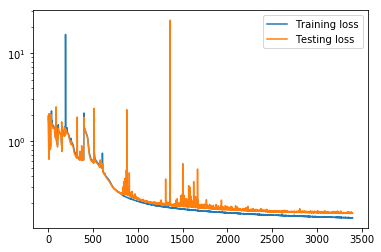

In [85]:
# Now let's train the initial network 

model = offCenterLineNet()
model = model.to(dev)
model.apply(weights_init_uniform)

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 3400

mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()


def network_loss(output_gt,output_line_params):
        relu = nn.ReLU()
        
        # Rule to apply:
        gt_a = -torch.sin(output_gt[:,0])
        gt_b = torch.cos(output_gt[:,0])
        gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
        
        gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)
        
#         # make the ground truth
#         c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
#         gt_line_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),dim=1)
        
        # calculate the loss
#         print(output_line_params[:,:,0,50])
    
        line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))
        line_loss =  mse_loss(output_line_params*line_in_image.unsqueeze(1),gt_line_params*line_in_image.unsqueeze(1))
        
        
        beta = 5
        
        # if |c| > sqrt(2) + beta, loss is 0
        # else loss increases to the maximum of sqrt(2) + beta when c = 0
        buffer_loss = torch.mean(~line_in_image*relu((np.sqrt(2) + beta - torch.abs(output_line_params[:,2]))))
        
#         buffer_loss = torch.mean(~line_in_image*(torch.abs(torch.abs(output_line_params[:,2]) - beta*(torch.abs(output_line_params[:,0]) + torch.abs(output_line_params[:,1])))))
        
        loss = line_loss + buffer_loss
        
        return loss


    
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 30:
        optimizer = torch.optim.Adam(model.parameters(),lr=.0005) 
        
        
    running_loss = 0
    num_batches = 0
    
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        inputs, output_gt, _, _ = data
        inputs, output_gt = inputs.to(dev), output_gt.to(dev)
        
        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        # forward pass to get outputs
        output_line_params = model(inputs)
        
        loss = network_loss(output_gt,output_line_params)
        
        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
      

#     scheduler.step()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1

            # Add code here
            inputs, output_gt, _, _ = data
            inputs, output_gt = inputs.to(dev), output_gt.to(dev)


            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_line_params = model(inputs)

            loss = network_loss(output_gt,output_line_params)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)
    
#     print('Epoch: {}, Avg. Train Loss: {},'.format(epoch + 1, train_loss_over_time[-1]))


    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

tensor([3.3103])
tensor([6.6114])
tensor([1.2541])
tensor([5.3323])
tensor([7.4123])
tensor([2.9748])
tensor([13.0324])


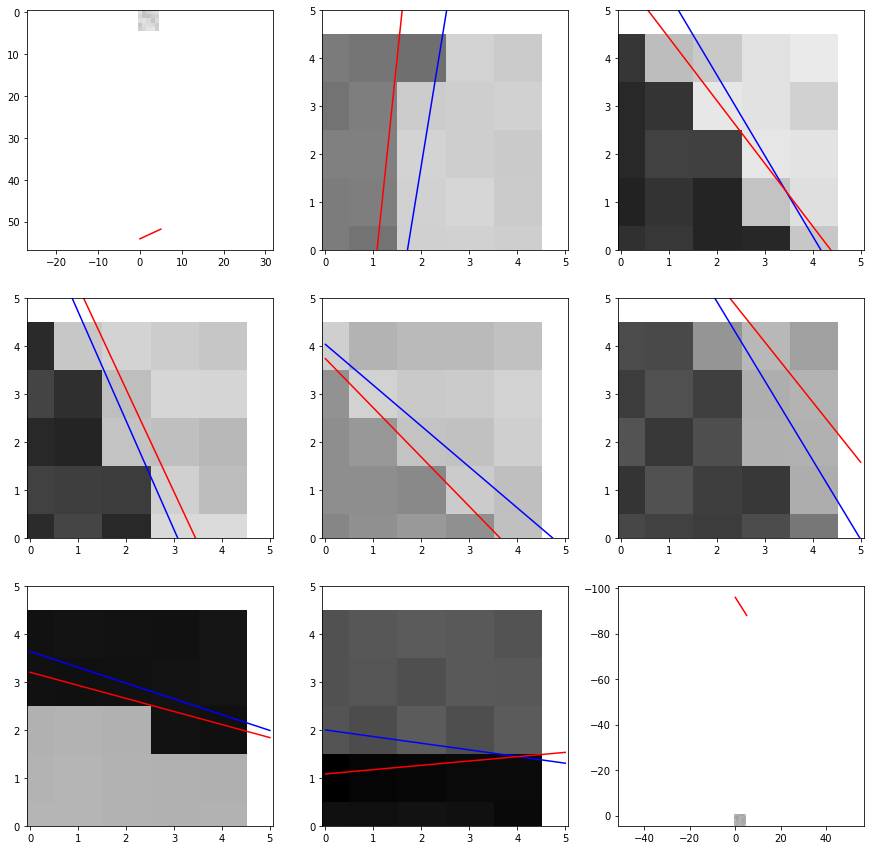

In [81]:
# Plot the Results

model.eval();

data = next(iter(test_loader))

# get the input images and their corresponding labels
inputs, output_gt, _, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()

c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])
angle_params = torch.stack((-torch.sin(output_gt[:,0]),torch.cos(output_gt[:,0]),c),axis=1).detach().cpu()

# Calculate angular loss
ang_loss = torch.abs(torch.rad2deg(torch.atan2(-angle_params[:,0]*outputs[:,1] + angle_params[:,1]*outputs[:,0]
                                     ,angle_params[:,1]*outputs[:,1]+angle_params[:,0]*outputs[:,0]).cpu()))


gt_a = -torch.sin(output_gt[:,0])
gt_b = torch.cos(output_gt[:,0])
gt_c = -output_gt[:,2]*torch.cos(output_gt[:,0]) + output_gt[:,1]*torch.sin(output_gt[:,0])

gt_line_params = torch.stack((gt_a,gt_b,gt_c),dim=1)

line_in_image = torch.abs(gt_c) < (torch.abs(gt_a) + torch.abs(gt_b))

    


plt.figure(figsize=[15, 15])

for ii in range(9):
    
    tt = torch.randint(len(inputs),[1])
    
    plt.subplot(3,3,ii+1)
    plt.imshow(inputs[tt].cpu().squeeze(),cmap='gray', vmin=0, vmax=1)
    plt.axis('equal')
    
    x_sample = torch.linspace(-1,1,inputs.shape[-1])
    
    if line_in_image[tt]:
    # Plot the ground truth lines
        y_sample = -angle_params[tt,0]/angle_params[tt,1]*x_sample - angle_params[tt,2]/angle_params[tt,1]

        plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'b')
        print(ang_loss[tt])
    
        plt.xlim([0,W])
        plt.ylim(([0,W]))
    
    # Plot the estimated lines
    y_est = -outputs[tt,0]/outputs[tt,1]*x_sample - outputs[tt,2]/outputs[tt,1]
    plt.plot(x_sample*W/2+W/2,y_est*W/2+W/2,'r')




In [ ]:
# %load_ext autoreload
# %reload_ext autoreload

In [54]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=2)
#         self.avgpool = nn.AvgPool2d(2)
        self.activate = nn.ReLU()
#         self.batchnorm = nn.BatchNorm2d(128)
    
    def forward(self, x):
        
#         mean, std = torch.mean(x), torch.std(x)
#         x  = (x-mean)/std
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)

        return out
    
R = 32 

big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, R, R))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]              80
              ReLU-2           [-1, 16, 31, 31]               0
            Conv2d-3           [-1, 16, 30, 30]           1,040
              ReLU-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 29, 29]           2,080
              ReLU-6           [-1, 32, 29, 29]               0
            Conv2d-7            [-1, 3, 28, 28]             387
Total params: 3,587
Trainable params: 3,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.88
Params size (MB): 0.01
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


In [399]:
# for name, child in model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                
# for name, child in big_model.named_children():
#             for name2, params in child.named_parameters():
#                 print(name, name2)
                

In [55]:
# Copy weights to the new network

offCenterLineNetWeights = model.state_dict()
offCenterLineNetWeightsBig = big_model.state_dict()

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    

In [463]:
# # Verify that the model outputs are the same when the input size is the patch size

# c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
# gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    
# print(gt_params)    

# print(big_model(wedges_grey).cpu().detach())
# print(model(wedges_grey).cpu().detach())

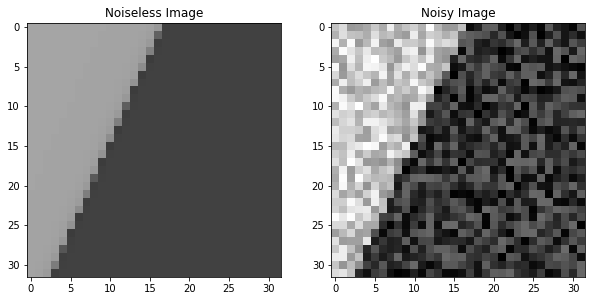

In [56]:
# Extract the network weights and process on a larger image:

# First produce a larger image:

R = 32
add_noise = 1
centered = 0
random_colors = 1
num_samples = 1

dists,wedges,boundaries,params = make_random_line_set(num_samples,R,'cpu',centered)

grey_transform = make_grey_transform(num_samples,wedges,'cpu',random_colors)

wedges_grey_noiseless = (wedges[:,:2,:,:,:,:]*grey_transform).sum(1).squeeze(1)

plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(wedges_grey_noiseless.squeeze(),cmap='gray', vmin=0, vmax=1)
plt.title('Noiseless Image')

wedges_grey = wedges_grey_noiseless.clone()

if add_noise:
    wedges_grey = wedges_grey_noiseless + .5*torch.rand(num_samples).unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape,device='cpu')
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 

plt.subplot(122)
plt.imshow(wedges_grey.squeeze(),cmap='gray', vmin=0, vmax=1)
plt.title('Noisy Image')

# print(params,torch.rad2deg(params[0,0,0,0]))

wedges_grey = wedges_grey.to(dev)

In [57]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3

num_convs = 2
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya

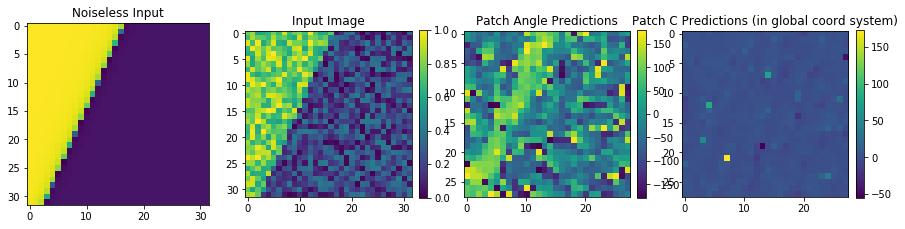

In [58]:
# wedges_grey = wedges_grey.to(dev)

output_line_params = big_model(wedges_grey).cpu().detach()

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


# x_sample = torch.linspace(-1,1,R)
# y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]

plt.figure(figsize=[15,15])
plt.subplot(141)
plt.imshow(wedges_grey_noiseless.squeeze())
plt.title('Noiseless Input')
# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
plt.subplot(142)
plt.imshow(wedges_grey.cpu().squeeze())
# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(143)
plt.imshow(output_line_angles)
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(144)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


Text(0.5, 1.0, 'Parameter Error')

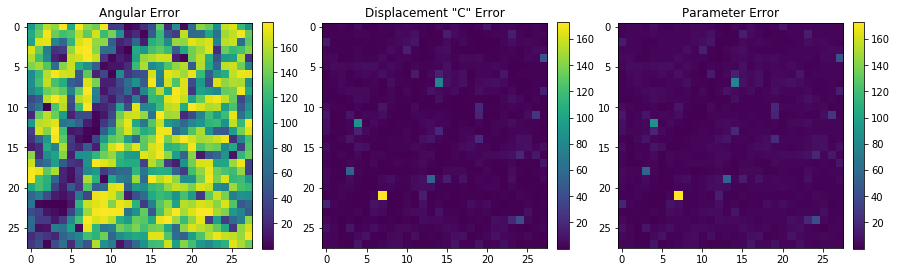

In [59]:
c = -params[:,2]*torch.cos(params[:,0]) + params[:,1]*torch.sin(params[:,0])
gt_params = torch.stack((-torch.sin(params[:,0]),torch.cos(params[:,0]),c),axis=1).detach().cpu()
    

# Calculate angular loss
ang_loss = torch.abs(torch.rad2deg(torch.atan2(-gt_params[:,0]*output_line_params_T[:,1] + gt_params[:,1]*output_line_params_T[:,0]
                                     ,gt_params[:,1]*output_line_params_T[:,1]+gt_params[:,0]*output_line_params_T[:,0]).cpu())).squeeze()

    
plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(ang_loss)
plt.title('Angular Error')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(torch.abs(c-output_line_params_T[:,2]).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Displacement "C" Error')
plt.subplot(133)
plt.imshow(torch.norm(output_line_params_T-gt_params,dim=1).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Parameter Error')


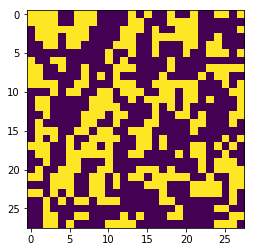

In [61]:
# Check for which patches satisfy inequality

# First convert to (cx,cy)
# cx,cy = -output_line_params[0,0,:,:]*output_line_params[0,2,:,:],output_line_params[0,1,:,:]*output_line_params[0,2,:,:]

# check_patches = (torch.abs(cy*output_line_params[0,1,:,:]) + torch.abs(cx*output_line_params[0,0,:,:])) < (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:]))
check_patches = (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:])) > torch.abs(output_line_params[0,2,:,:])


plt.figure()
plt.imshow(check_patches)



gt C= tensor([[[-0.3031]]])
mode C= tensor(-1.6939)
gt angle= tensor([[245.5548]])
mode angle= tensor(-125.9036)


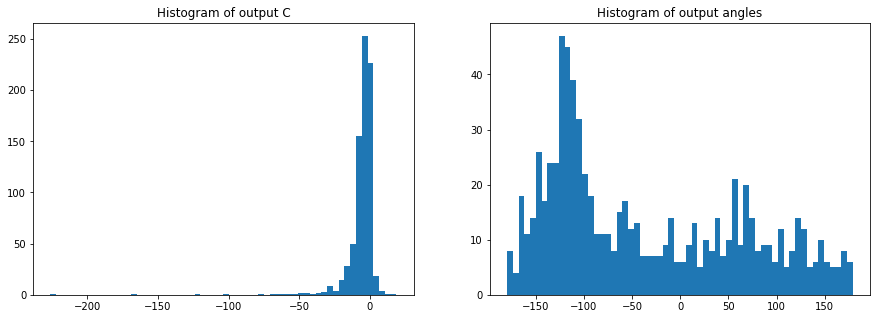

In [28]:
# Make C histogram

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(output_line_params_T.squeeze()[2,:,:].ravel(),bins=60);
plt.title('Histogram of output C')

print('gt C=',c)
# print('center C=',output_line_disp[16,16])

weight=torch.histogram(output_line_params_T.ravel(), bins=60)
print('mode C=',weight[1][torch.argmax(weight[0])])


# Next, angles:

plt.subplot(122)
plt.hist(output_line_angles.ravel(),bins=60)
plt.title('Histogram of output angles')

print('gt angle=',torch.rad2deg(params[0][0]))
# print('center angle=',output_line_angles[16,16])

weight=torch.histogram(output_line_angles.ravel(), bins=60)
print('mode angle=',weight[1][torch.argmax(weight[0])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 26, 26])


Text(0.5, 1.0, 'Variance of C Clipped')

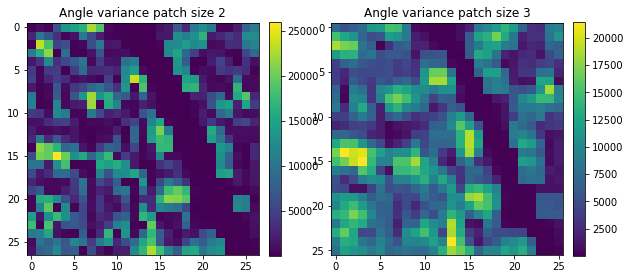

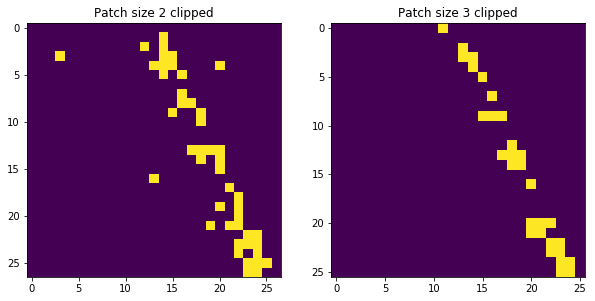

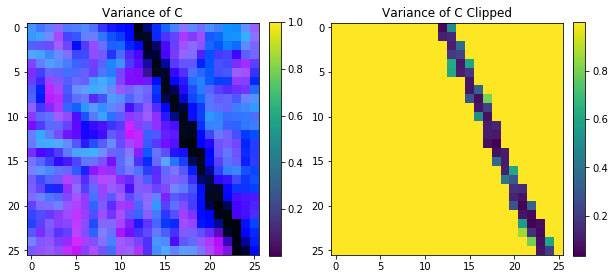

In [29]:
# Calculate patch variance of output line_angles

ker_size = 2

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 3

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[10,10])
plt.title('Variance of Angles')
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.title('Angle variance patch size 2')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.title('Angle variance patch size 3')
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[10,10])
plt.subplot(121)
low_var = running_var.squeeze()<50
low_var_2 = running_var_2.squeeze()<100

plt.imshow(low_var)
plt.title('Patch size 2 clipped')
plt.subplot(122)
plt.imshow(low_var_2)
plt.title('Patch size 3 clipped')
# plt.colorbar()


# Figure out why this visualization is so good

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Variance of C')
# plt.figure(figsize=[15,15])
plt.subplot(122)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Variance of C Clipped')


# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))




torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


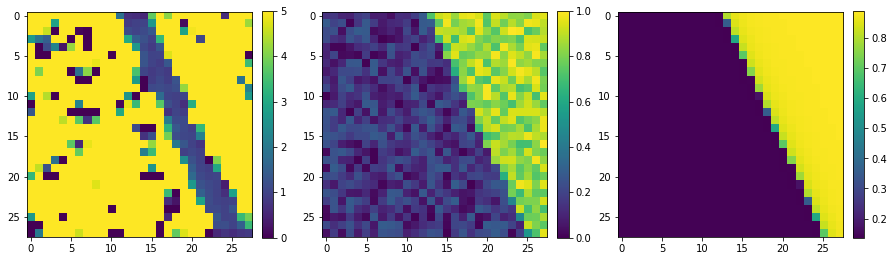

In [30]:
# How diffferent is each patch from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


dot_prod = torch.sum(avg_patch_params*output_line_params_T,1).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

x_sample = torch.linspace(-1,1,8)
y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,5))
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(wedges_grey_noiseless.cpu().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')

# Measure how different 

torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


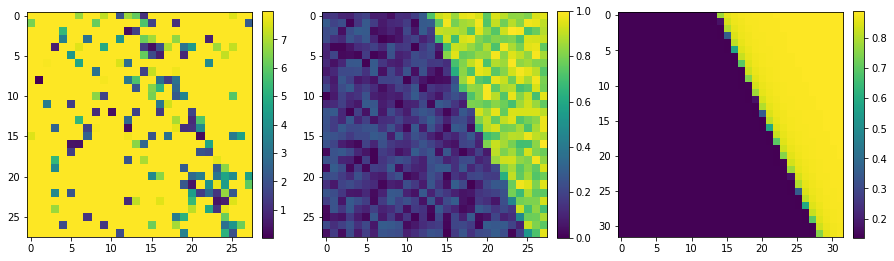

In [31]:
# How diffferent is each patch angle from its neighborhood of patches:

ker_size = 3
avg_angle_param = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))

print(avg_angle_param.shape)
print(output_line_params_T.shape)

# Calculate angular loss
ang_diff = torch.abs(torch.rad2deg(torch.atan2(-avg_angle_param[:,0,:,:]*output_line_params_T[:,1,:,:] + avg_angle_param[:,1,:,:]*output_line_params_T[:,0,:,:]
                                     ,avg_angle_param[:,1,:,:]*output_line_params_T[:,1,:,:]+avg_angle_param[:,0,:,:]*output_line_params_T[:,0,:,:]).cpu())).squeeze()


x_sample = torch.linspace(-1,1,8)
y_sample = -gt_params[0,0,0,0]/gt_params[0,1,0,0]*x_sample - gt_params[0,2,0,0]/gt_params[0,1,0,0]


plt.figure(figsize=[15,15])
plt.subplot(131)
# plt.imshow(dot_prod)
plt.imshow(ang_diff)
plt.imshow(np.clip(ang_diff,0,8))
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
# plt.xlim([0,W])
# plt.ylim(([0,W]))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(wedges_grey_noiseless.cpu().squeeze())
plt.colorbar(fraction=0.046, pad=0.04)


# Plot the ground truth lines

# plt.plot(x_sample*W/2+W/2,y_sample*W/2+W/2,'r')
# plt.xlim([0,W])
# plt.ylim(([0,W]))


    
# Measure how different 


In [32]:
def make_random_junction_set(num_samples,img_size,opts,dev,eta=.01,delta=.02):

#     img_size = 64
    img = np.zeros((img_size,img_size,1))

    opts.R                        = img_size
    opts.stride                   = img_size
    opts.eta                      = 0.01
    opts.delta                    = 0.02
    opts.lr_angles                = 0.003
    opts.lr_x0y0                  = 0.03
    opts.lambda_boundary_final    = 0.5
    opts.lambda_color_final       = 0.1
    opts.nvals                    = 31
    opts.num_initialization_iters = 30
    opts.num_refinement_iters     = 1000
    opts.greedy_step_every_iters  = 50
    opts.parallel_mode            = True

#     dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    foj = FieldOfJunctions(img, dev, opts)

    # Bounds of image: [-1,1],[-1,1]
    # Randomly generate junction location from [-3,3],[3,3] and 3 angles between [0,2*pi]

#     jcenter = 2*torch.rand(num_samples,2) - 1
#     jangles = 2*np.pi*torch.rand(num_samples,3) - np.pi
    jangles = 2*np.pi*torch.rand(num_samples,3).to(dev)
#     jcenter = .9*torch.rand(num_samples,2).to(device) - .9
    jcenter = (.2*torch.rand(num_samples,2) - .2).to(dev)
    params = torch.cat([jangles,jcenter],dim=1).unsqueeze(2).unsqueeze(3)
    
    dists = foj.params2dists(params)
    wedges = foj.dists2indicators(dists).squeeze(-1).squeeze(-1)

    params = params
    
    print(wedges.shape)
    
    return dists,wedges,params,foj


def make_grey_transform_junc(num_images,dev,opt=0):
    
    if opt == 0:
        return torch.tensor([0,.5,1]).unsqueeze(0).unsqueeze(2).unsqueeze(2)

    if opt == 1:  

        grey_transform = torch.zeros((wedges.shape[0],3,1,1),device=dev)

        num_grey_schemes = 0
        while num_grey_schemes<wedges.shape[0]:
            
            sample = torch.rand(3,device=dev).sort()[0]

            if torch.max(torch.diff(sample))<.2:
                continue

            grey_transform[num_grey_schemes,:,:,:] = sample.unsqueeze(1).unsqueeze(1)

            num_grey_schemes += 1

        return grey_transform

torch.Size([1, 3, 32, 32])
tensor([[[[0.2805]],

         [[0.5044]],

         [[0.5806]]]])


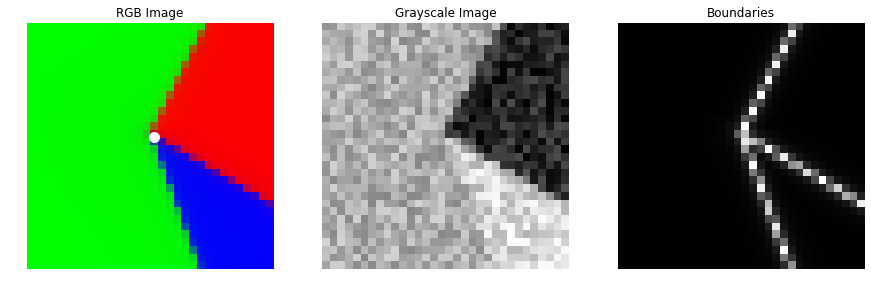

In [34]:
# Produce a junction image

R = 32
add_noise = 1


opts = SimpleNamespace()
dists,wedges,params,foj = make_random_junction_set(1,R,opts,'cpu')

grey_transform = make_grey_transform_junc(wedges.shape[0],'cpu',opt=1)

print(grey_transform)

wedges_grey = (wedges*grey_transform).sum(1)
boundaries = foj.dists2boundaries(dists).squeeze(1).squeeze(3).squeeze(3)

if add_noise:
    wedges_grey = wedges_grey + .2*torch.rand(num_samples,device='cpu').unsqueeze(1).unsqueeze(1).unsqueeze(1)*torch.rand(*wedges_grey.shape,device='cpu')
    mn, mx = wedges_grey.min(), wedges_grey.max()

    # Adjust contrast (equally to both images)
    wedges_grey = (wedges_grey - mn) / (mx - mn) 


img_show = 0

# TO DO: figure out how to plot the junction center!!
junction_center = (params[img_show,-2:,:,:].squeeze()*R/2 + R/2).cpu()

# print(junction_center)


plt.figure(figsize=[15, 15])
plt.subplot(131)
plt.imshow(wedges[img_show,:,:].permute(1,2,0))
plt.plot(junction_center[0],junction_center[1],'wo',markersize=10)
plt.title('RGB Image')
plt.axis('off');
plt.subplot(132)
plt.imshow(wedges_grey[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(133)
plt.imshow(boundaries[img_show,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Boundaries')
plt.axis('off');

wedges_grey = wedges_grey.to(dev)#.unsqueeze(0)


In [35]:
# Make Transformation matrix L

# Each patch needs to be transformed by a different 3 x 3 transformation
# Assuming zero-padding, the output of the network will 64 x 64 x 3
# The transformation will be 64 x 64 x 3 x 3
# Hence, we need to add an additional input to the dimension to make it: 64 x 64 x 1 x 3

num_convs = 2
Wn,Hn = big_model(wedges_grey).shape[-1],big_model(wedges_grey).shape[-1]


# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device='cpu'),torch.zeros((Wn,Hn),device='cpu')

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+num_convs/W, 1.0-num_convs/W, Wn, device='cpu'),
                               torch.linspace(-1.0+num_convs/H, 1.0-num_convs/H, Hn, device='cpu')])

L = torch.zeros((1,3,3,Hn,Wn),device='cpu')#torch.tensor([[1-x0,0,0],[0,1-y0,0],[0,0,1]])
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


torch.Size([1, 3, 28, 28])


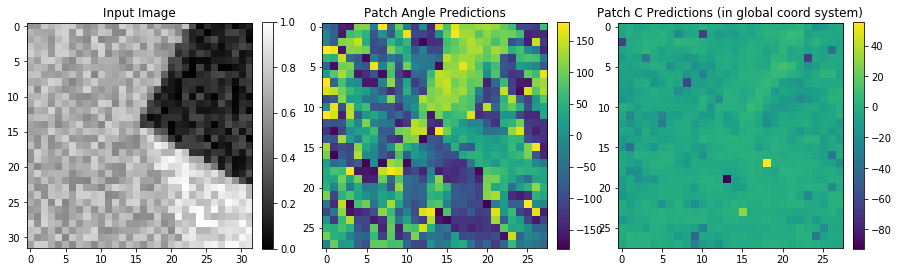

In [36]:
output_line_params = big_model(wedges_grey).cpu().detach()

print(output_line_params.shape)

# I need to transform this into a global coordinate system

# transform each patch into global coordinate system
output_line_params_T = torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# output_line_params_plot = output_line_params_trans.clone() + 1
# output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
output_line_disp = output_line_params_T[0,2,:,:]


plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(wedges_grey.cpu().detach().squeeze(),cmap='gray',vmin=0,vmax=1)
plt.title('Input Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(output_line_angles,vmin=-180,vmax=180)
plt.title('Patch Angle Predictions')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(output_line_disp)
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)


In [311]:
# # Issue: not enough separation of color

# # What if we normalizae the input image first

# input_img = wedges_grey[:,:,:10,15:25]

# # mean, std, var = torch.mean(input_img), torch.std(input_img), torch.var(input_img)

# # input_img = (input_img-mean)/std

# output_line_params = big_model(input_img).cpu().detach()

# print(output_line_params.shape)

# # I need to transform this into a global coordinate system

# # transform each patch into global coordinate system
# output_line_params_T = output_line_params#torch.einsum('ajbc,ajkbc->akbc',output_line_params,L)

# # output_line_params_plot = output_line_params_trans.clone() + 1
# # output_line_params_plot = output_line_params_plot/torch.max(output_line_params_plot)

# output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
# output_line_disp = output_line_params_T[0,2,:,:]


# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(input_img.cpu().detach().squeeze())
# plt.title('Input Image')
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(output_line_angles,vmin=-180,vmax=180)
# plt.title('Patch Angle Predictions')
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(output_line_disp)
# plt.title('Patch C Predictions (in global coord system)')
# plt.colorbar(fraction=0.046, pad=0.04)





tensor([ 0.5672,  0.8236, -3.6508])
tensor([ 0.8484,  0.5293, -5.3992])
torch.Size([1, 3, 28, 28])
tensor([ 0.5672,  0.8236, -3.6508])


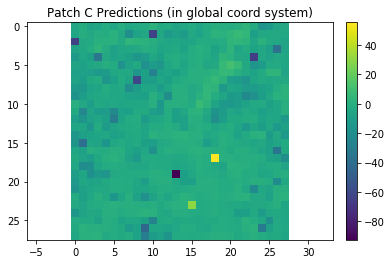

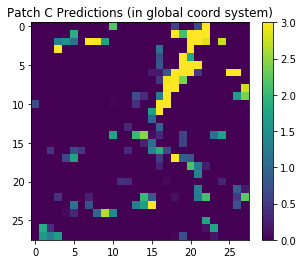

In [37]:
R = 32

line_test = output_line_params_T[0,:,5,12]

print(output_line_params_T[0,:,5,12])
print(output_line_params_T[0,:,6,12])

x_sample = torch.linspace(-1,1,8)
y_sample = -line_test[0]/line_test[1]*x_sample - line_test[2]/line_test[1]


plt.figure()
plt.imshow(output_line_disp)
# plt.plot(5,12,'rx')
# plt.plot(x_sample*R/2+R/2,y_sample*R/2+R/2,'r')
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('equal')


print(output_line_params.shape)
print(line_test)

plt.figure()
plt.imshow(np.clip(output_line_disp,0,3))
plt.title('Patch C Predictions (in global coord system)')
plt.colorbar(fraction=0.046, pad=0.04)

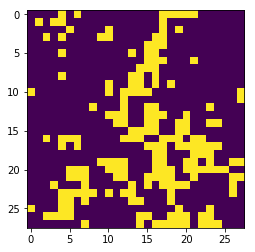

In [38]:
check_patches = (torch.abs(output_line_params[0,0,:,:]) + torch.abs(output_line_params[0,1,:,:])) > torch.abs(output_line_params[0,2,:,:])


plt.figure()
plt.imshow(check_patches)

# c = output_line_params[0,2,:,:]
# a = output_line_params[0,0,:,:]
# b = output_line_params[0,1,:,:]

# plot1 =  torch.abs(c) < (torch.abs(a + b))
# plot2 = torch.abs(c) < (torch.abs(a - b))

# plt.figure()
# plt.subplot(121)
# plt.imshow(plot1, extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')
# plt.subplot(122)
# plt.imshow(plot2, extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')

# plt.figure()
# plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
# plt.plot(1,1,'rx')

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(torch.abs(a + b), extent=[-2,2,-2,2])
# plt.subplot(132)
# plt.imshow(torch.abs(a - b), extent=[-2,2,-2,2])
# plt.subplot(133)
# plt.imshow(torch.abs(a)+torch.abs(b), extent=[-2,2,-2,2])




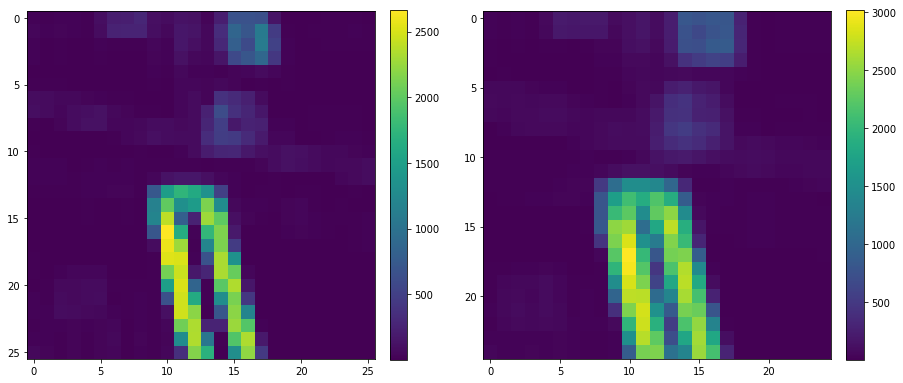

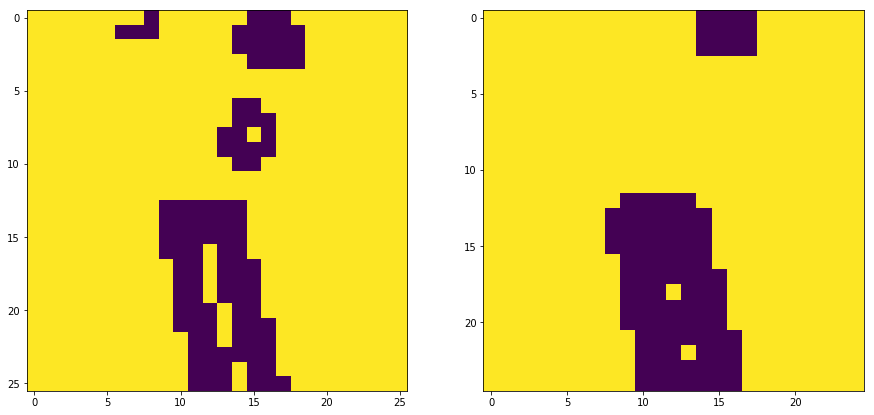

In [132]:
ker_size = 3

running_var = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

ker_size = 4

running_var_2 = F.avg_pool2d(output_line_angles.unsqueeze(0)**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_angles.unsqueeze(0), kernel_size=ker_size,stride=1)**2

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(running_var_2.squeeze())
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)

low_var = running_var.squeeze()<250
low_var_2 = running_var_2.squeeze()<600

plt.imshow(low_var)
plt.subplot(122)
plt.imshow(low_var_2)
# plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 26, 26])


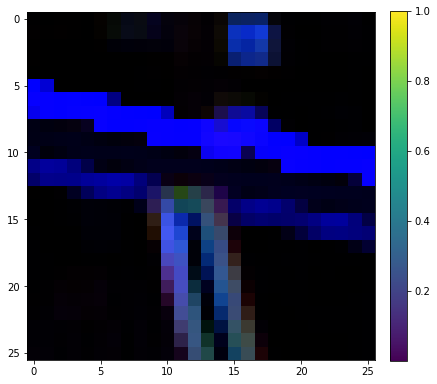

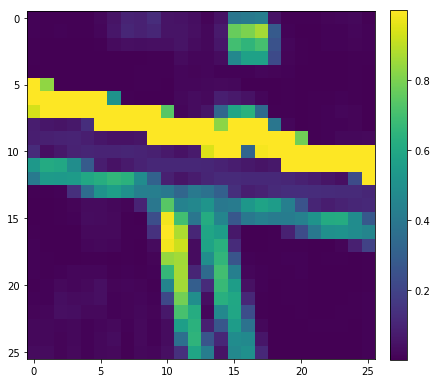

In [133]:
# Visualize variance

ker_size = 3

running_var = F.avg_pool2d(output_line_params_T**2, kernel_size=ker_size, stride=1) - F.avg_pool2d(output_line_params_T, kernel_size=ker_size,stride=1)**2
m = nn.Threshold(1, 1)

print(running_var.shape)


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(running_var.squeeze().permute(1,2,0))
plt.colorbar(fraction=0.046, pad=0.04)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.clip(torch.linalg.norm(running_var.squeeze().permute(1,2,0),dim=2),0,1))
plt.colorbar(fraction=0.046, pad=0.04)

# plt.figure(figsize=[15,15])
# plt.subplot(131)
# plt.imshow(running_var.squeeze()[0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(running_var.squeeze()[1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(m(running_var.squeeze()[2]))
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# plt.imshow(running_var_2.squeeze())
# plt.colorbar(fraction=0.046, pad=0.04)

# plt.subplot(122)
# low_var = running_var.squeeze()<500

# plt.imshow(low_var.permute(1,2,0))



torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


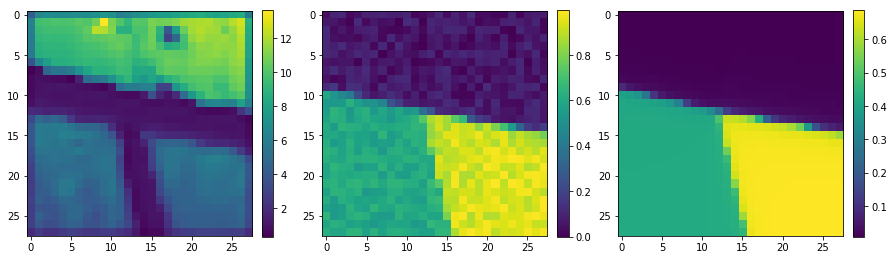

In [134]:
# How diffferent is each patch from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


dot_prod = torch.sum(avg_patch_params*output_line_params_T,1).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,20))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

# Measure how different 

torch.Size([1, 3, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 32, 32])


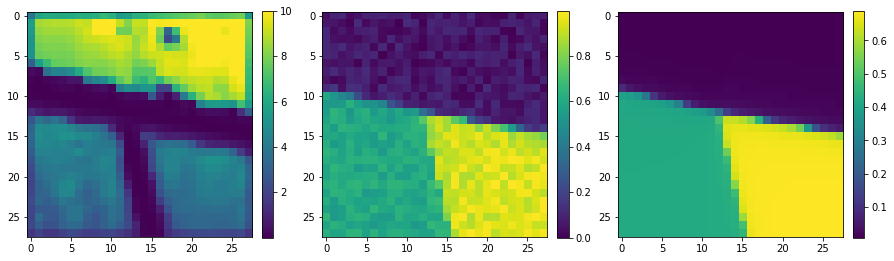

In [135]:
# How diffferent is each patch angle from its neighborhood of patches:

ker_size = 3
avg_patch_params = F.avg_pool2d(output_line_params_T, kernel_size=ker_size, stride=1, padding=(1,1))


#dot_prod = torch.sum(avg_patch_params[:,:2,:,:]*output_line_params_T[:,:2,:,:],1).squeeze()

dot_prod = torch.abs(avg_patch_params[:,2,:,:]*output_line_params_T[:,2,:,:]).squeeze()

print(output_line_params_T.shape)
print(dot_prod.shape)
print(wedges_grey.shape)

plt.figure(figsize=[15,15])
plt.subplot(131)
# plt.imshow(dot_prod)
plt.imshow(np.clip(dot_prod,0,10))
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(wedges_grey.cpu().detach().squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow((wedges*grey_transform).sum(1).squeeze()[2:-2,2:-2])
plt.colorbar(fraction=0.046, pad=0.04)

# Measure how different 

In [121]:
# Use inlier/outlier based on variance 

def intersect(P0,P1):
    """P0 and P1 are NxD arrays defining N lines.
    D is the dimension of the space. This function 
    returns the least squares intersection of the N
    lines from the system given by eq. 13 in 
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf.
    """
    # generate all line direction vectors 
    n = (P1-P0)/np.linalg.norm(P1-P0,axis=1)[:,np.newaxis] # normalized

    # generate the array of all projectors 
    projs = np.eye(n.shape[1]) - n[:,:,np.newaxis]*n[:,np.newaxis]  # I - n*n.T
    # see fig. 1 

    # generate R matrix and q vector
    R = projs.sum(axis=0)
    q = (projs @ P0[:,:,np.newaxis]).sum(axis=0)

    # solve the least squares problem for the 
    # intersection point p: Rp = q
    p = np.linalg.lstsq(R,q,rcond=None)[0]

    return p



In [ ]:
p = intersect

tensor([[[[-0.8851,  0.4653, -0.1441]]]])
tensor([[[[-0.6472,  0.7624, -0.0786]]]])
tensor([[[[ 0.1974, -0.9803, -0.0234]]]])
torch.Size([1, 28, 28, 3]) torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


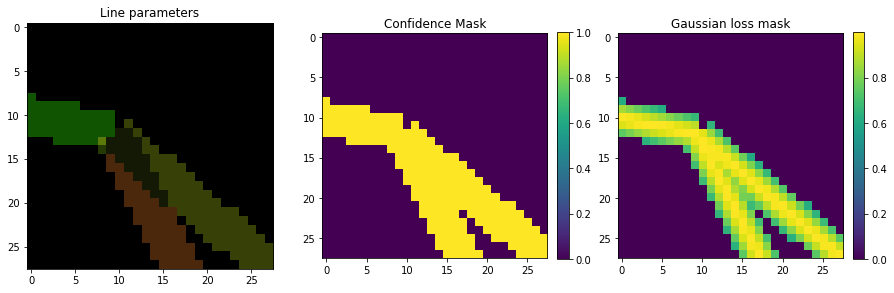

In [43]:
# Let's start by just training the initial neural network with known GT

# Given a set of line parameters, construct the ground truth:

def make_ground_truth(params,H,x0,y0,rf):
        
        theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        cx = params[:,3]
        cy = params[:,4]
                 
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        
#         a[:,1:,:,:] = - a[:,1:,:,:]
#         b[:,1:,:,:] = - b[:,1:,:,:]
#         c[:,1:,:,:] = - c[:,1:,:,:]
        
        # radius threshold 
#         rf = 15 # receptive field size (in the original image)
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        # Create a gaussian mask that is the distance from the line
        sig = .1
        mask3 = torch.exp(-(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)**2/(2*sig**2))

        full_mask = mask1*mask2#*mask3
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        line_params = torch.stack((a,b,c),dim=4)
        

        print(line_params[:,0,:,:,:])
        print(line_params[:,1,:,:,:])
        print(line_params[:,2,:,:,:])
        
#         line_params[:,1,:,:,:] = - line_params[:,1,:,:,:]
#         line_params[:,2,:,:,:] = - line_params[:,2,:,:,:]
        line_params[:,0,:,:,:] = - line_params[:,0,:,:,:]
        
        ground_truth = torch.mean(line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        
#         confidence = mask2*mask3
#         confidence = confidence/torch.max(confidence.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)
#         confidence,_ = torch.max(confidence,1)
        confidence,_ = torch.max(mask1*mask2,1)#.float()
    
        gaussian_mask,_ = torch.max(mask1*mask2*mask3,1)
        
        return ground_truth,confidence.float(),gaussian_mask
    
gt,c,gm = make_ground_truth(params[:,:,0,0],R,x0,y0,8)

print(gt.shape,c.shape,gm.shape)

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(torch.abs(gt[0].squeeze().cpu()))
# plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Line parameters')
plt.subplot(132)
plt.imshow(c[0].squeeze().cpu())
plt.title('Confidence Mask')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(133)
plt.imshow(gm[0].squeeze().cpu())
plt.title('Gaussian loss mask')
# plt.subplots_adjust(wspace=0, hspace=.15)
plt.colorbar(fraction=0.046, pad=0.04)

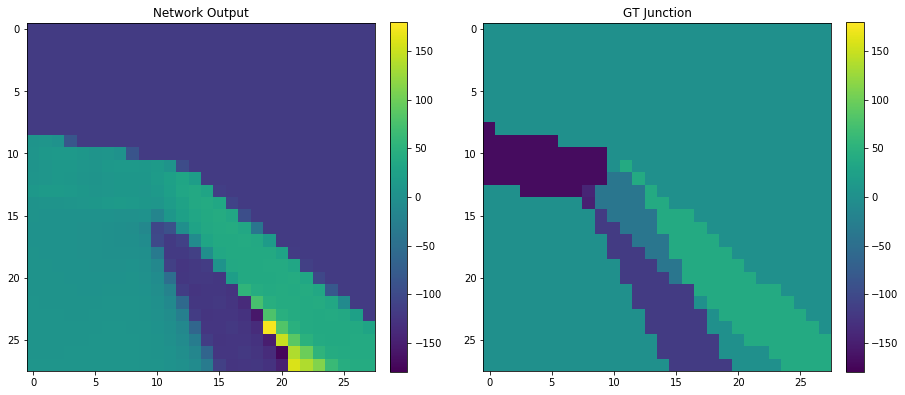

In [44]:
# print(torch.rad2deg(params[0,:3]))

# plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.imshow(gt[0,:,:,0])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(132)
# plt.imshow(gt[0,:,:,1])
# plt.colorbar(fraction=0.046, pad=0.04)
# plt.subplot(133)
# plt.imshow(gt[0,:,:,2])
# # plt.subplots_adjust(wspace=0, hspace=.15)
# plt.colorbar(fraction=0.046, pad=0.04)

#output_line_angles = torch.rad2deg(torch.atan2(-output_line_params[0,0,:,:],output_line_params[0,1,:,:]))
gt_line_angles = torch.rad2deg(torch.atan2(-gt[0,:,:,0],gt[0,:,:,1]))


plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(output_line_angles,vmin=-180,vmax=180)
plt.title('Network Output')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(gt_line_angles,vmin=-180,vmax=180)
plt.title('GT Junction')
plt.colorbar(fraction=0.046, pad=0.04)


torch.Size([28, 28])
torch.Size([28, 28])


Text(0.5, 1.0, 'GT Angles')

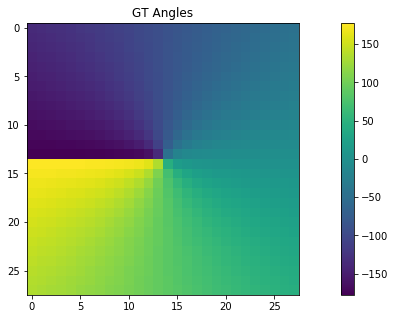

In [45]:
# Ground truth angles

print(x0.shape)
print(y0.shape)

angle_basis = torch.rad2deg(torch.atan2(y0,x0)) 

plt.figure(figsize=[15,5])
plt.imshow(angle_basis)
plt.colorbar()
plt.title('GT Angles')



torch.Size([1, 3, 28, 28])
torch.Size([1, 3, 28, 28])


Text(0.5, 1.0, 'Overall Parameter (a,b,c) Error')

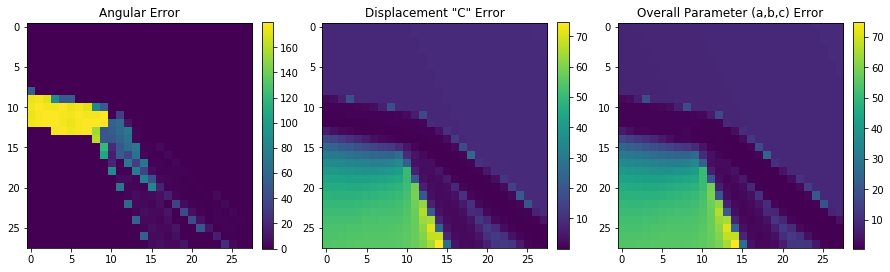

In [46]:
gt_params = gt.permute(0,3,1,2)
    
print(gt_params.shape) 
print(output_line_params_T.shape)
# Calculate angular loss

ang_loss = torch.abs(torch.rad2deg(torch.atan2(-gt_params[:,0,:,:]*output_line_params_T[:,1,:,:] + gt_params[:,1,:,:]*output_line_params_T[:,0,:,:]
                                     ,gt_params[:,1,:,:]*output_line_params_T[:,1,:,:]+gt_params[:,0,:,:]*output_line_params_T[:,0,:,:]).cpu())).squeeze()
    
    
plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(ang_loss*c[0].squeeze().cpu())
plt.title('Angular Error')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(132)
plt.imshow(torch.abs(gt_params[:,2,:,:]-output_line_params_T[:,2,:,:]).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Displacement "C" Error')
plt.subplot(133)
plt.imshow(torch.norm(output_line_params_T-gt_params,dim=1).squeeze())
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Overall Parameter (a,b,c) Error')


In [ ]:
# Find variance of original image divided according to line parameters 